# Example 3 - Ferry Service with Deterministic Demand



Let's make life easy for this one and assume the following set up:


- A ferry (or whatever) has remaining capacity S (not C, because remaining capacity is our state variable).
- Each period, the operator can set a price to sell space at.
- The ferry faces a fixed deterministic demand given by

$$q = A e^{-kp}$$

- In a given period, the operator sets price and realizes demand. The remaining capacity they take into next period is

$$ s^{\prime} = \max\{ s - q, 0\} $$

That is, if they can't satisfy demand with the remaining space they sell nothing.

- The period payoff is 

$$ p (s - s^{\prime}) $$

## Libraries

In [1]:
import numpy as np
import pandas as pd

from rich import print
from rich.pretty import pprint

from markov_decision_process import TimeAugmentedMDP


import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("deep")
%matplotlib inline

import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
## Parameters
A = 10
K = 0.05


def demand(price):
    # Let demand be linear in price
    # It can't be less than 0
    # q = 10 - .15*price
    q = A * np.exp(-K * price)

    # Round q to the nearest half
    q = np.round(q * 2) / 2

    return np.clip(q, 0, None)

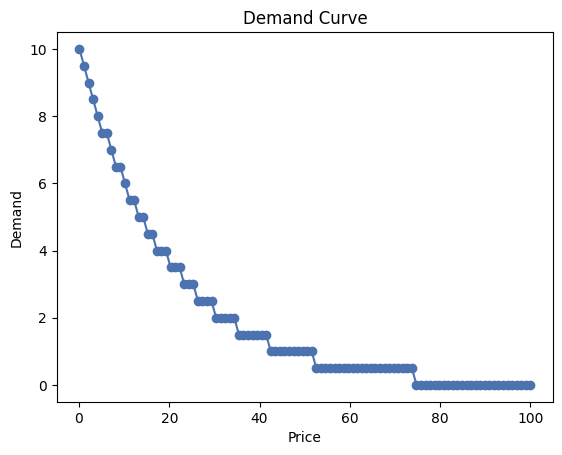

In [3]:
# Plot our demand curve

x = np.linspace(1e-1, 100, 100)
y = demand(x)

plt.scatter(x, y)
plt.plot(x, y)
plt.xlabel("Price")
plt.ylabel("Demand")
plt.title("Demand Curve")
plt.show()

In [4]:
## Important: The reason for the rounding there is because otherwise there will never be a case
## where the s_prime that's computed is actually in the state space.

## Problem Setup

Note that in this problem we have a large state and action space. To have this compute efficiently, we 
need to ensure that our transition and reward functions are vectorized; in the sense that they will accept numpy arrays/pandas colums.

In [5]:
# Use a grid for the state space. We'll have max capacity be 100
max_capacity: float = 100

states: list[float] = np.linspace(0, max_capacity, 31).tolist()
actions: list[float] = np.linspace(1, 100, 11).tolist()
times: list[int] = np.arange(-30, 1).tolist()


def reward(
    s_prime: float,
    s: float,
    a: float,
    t: int,
) -> float:
    return a * (s - s_prime)


def transition(
    s_prime: float,
    s: float,
    a: float,
    t: int,
) -> float:
    # Vectorized computation using Polars expressions
    q = demand(a)
    return (s_prime == np.clip(s - q, 0, None)).astype(int)

In [6]:
%%time
# Let's split these up to time them
mdp = TimeAugmentedMDP(
    states=states,
    actions=actions,
    times=times,
    reward_function=reward,
    transition_function=transition,
    state_space_data_path="/tmp/state_space_data/",
    force_overwrite=True,
)
mdp.solve()

# Note we're using solve_vectorized here because we have a big grid and our
# transition/reward function is vectorized

INFO:markov_decision_process.time_augmented_mdp:Mode not set. Inferring mode...
INFO:markov_decision_process.time_augmented_mdp:Reward function is vectorized: True
INFO:markov_decision_process.time_augmented_mdp:Transition function is vectorized: True
INFO:markov_decision_process.time_augmented_mdp:Reward and transition functions are vectorized. Setting mode to "vectorized"
INFO:markov_decision_process.time_augmented_mdp:State space augmented with time
INFO:markov_decision_process.time_augmented_mdp:Generating state space data...
INFO:markov_decision_process.time_augmented_mdp:No data found on disk. Generating...
INFO:markov_decision_process.time_augmented_mdp:State space data generated and saved to disk
INFO:markov_decision_process.time_augmented_mdp:Generating rewards and transitions...


TypeError: cannot convert Python type 'ndarray' to Float64

In [7]:
# Note that most of the time here is spent setting up the matrices. The actual
# solve time is neglitible.

In [8]:
period = -20

x = mdp.policy_function[period].keys()
policy = mdp.policy_function[period].values()
value = mdp.value_function[period].values()

# Remove state 0
x = list(x)[1:]
policy = list(policy)[1:]
value = list(value)[1:]


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(x, policy)
ax[0].plot(x, policy)
ax[0].set_title("Policy Function")
ax[0].set_xlabel("State")
ax[0].set_ylabel("Price")
ax[0].set_ylim(0, 100)

ax[1].scatter(x, value)
ax[1].plot(x, value)
ax[1].set_title("Value Function")
ax[1].set_xlabel("State")
ax[1].set_ylabel("Value")

plt.show()

AttributeError: 'TimeAugmentedMDP' object has no attribute 'policy_function'

In [ ]:
# Hey! That's a monotone value function, that's good! More of the state should be better than less.

# The policy likely has those little departures from monotone because of tie breakers (two or more prices are equally good and it picks one).

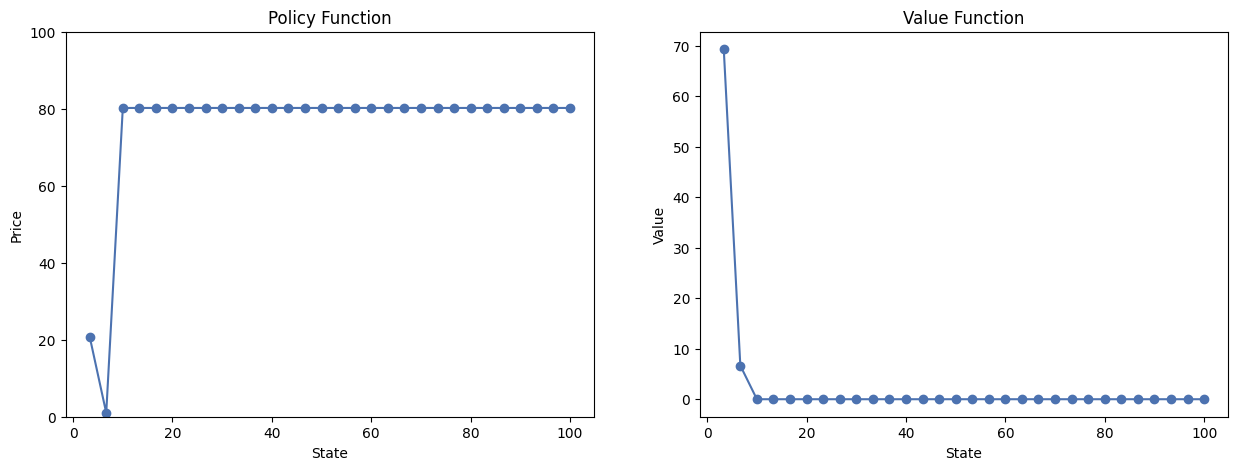

In [ ]:
period = max(mdp.times) - 1

x = mdp.policy_function[period].keys()
policy = mdp.policy_function[period].values()
value = mdp.value_function[period].values()

# Remove state 0
x = list(x)[1:]
policy = list(policy)[1:]
value = list(value)[1:]


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(x, policy)
ax[0].plot(x, policy)
ax[0].set_title("Policy Function")
ax[0].set_xlabel("State")
ax[0].set_ylabel("Price")
ax[0].set_ylim(0, 100)

ax[1].scatter(x, value)
ax[1].plot(x, value)
ax[1].set_title("Value Function")
ax[1].set_xlabel("State")
ax[1].set_ylabel("Value")

plt.show()

In [ ]:
# If there's only one selling period left, then it makes sense that we should set a lower price to sell more if we have lots of spare capacity.

# When we have very little spare capacity, we should set a higher price to sell less.

In [ ]:
## Plot transitions

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

mdp.plot_matrix(matrix_type="transitions", t=0, a=mdp.A[10], ax=ax[0])
mdp.plot_matrix(matrix_type="transitions", t=0, a=mdp.A[40], ax=ax[1])


plt.show()

### Deterministic booking curve

Let's simulate a booking curve where we get few bookings far out from departure, and many bookings close to departure.

In [ ]:
# Function to turn time horizon from -30 to 0 into 1 - 2
def transform_range(value, old_min=-30, old_max=0, new_min=0, new_max=20):
    scale = (new_max - new_min) / (old_max - old_min)

    # Transform the value
    transformed_value = new_min + (value - old_min) * scale

    return transformed_value

In [ ]:
A = 10
K = 0.05


def demand(price, t):
    # Let demand be linear in price
    # It can't be less than 0
    # q = 10 - .15*price
    factor = transform_range(t)

    q = A * np.exp(-K * (price - factor) * 0.1 * np.abs(t))

    # Round q to the nearest half
    q = np.round(q * 2) / 2

    return np.clip(q, 0, None)

In [ ]:
# Plot our demand curve

t = [-30, -20, -10]
x = np.linspace(1e-1, 100, 100)

# Make a data frame that contains the cross join of x and t

df = pd.DataFrame({"x": x})
df["key"] = 1
df2 = pd.DataFrame({"t": t})
df2["key"] = 1
df = df.merge(df2, on="key")
df.drop("key", axis=1, inplace=True)

# Compute demand
df["demand"] = df.apply(lambda x: demand(x["x"], x["t"]), axis=1)


plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=df,
    x="x",
    y="demand",
    hue="t",
)
plt.xlabel("Price")
plt.ylabel("Demand")
plt.title("Demand Curve")
plt.show()

In [ ]:
class MDPProblem(TimeAugmentedMDP):
    def __init__(self):
        super().__init__()

        # Use a grid for the state space. We'll have max capacity be 100
        max_capacity: float = 100

        self.S: list[float] = np.linspace(0, max_capacity, 201).tolist()

        self.A: list[float] = np.linspace(1, 100, 101).tolist()

        self.T: list[int] = np.arange(-30, 1).tolist()

        return None

    def reward(
        self,
        s_prime: float,
        s: float,
        t: int,
        a: float,
    ) -> float:
        return a * (s - s_prime)

    def transition(
        self,
        s_prime: float,
        s: float,
        t: int,
        a: float,
    ) -> float:
        q = demand(a, t)
        return (s_prime == np.clip(s - q, 0, None)).astype(int)

In [ ]:
mdp = MDPProblem()
mdp.solve_vectorized()

In [ ]:
period = -30

x = mdp.policy_function[period].keys()
policy = mdp.policy_function[period].values()
value = mdp.value_function[period].values()

# Remove state 0
x = list(x)[1:]
policy = list(policy)[1:]
value = list(value)[1:]


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(x, policy)
ax[0].plot(x, policy)
ax[0].set_title("Policy Function")
ax[0].set_xlabel("State")
ax[0].set_ylabel("Price")
ax[0].set_ylim(0, 100)

ax[1].scatter(x, value)
ax[1].plot(x, value)
ax[1].set_title("Value Function")
ax[1].set_xlabel("State")
ax[1].set_ylabel("Value")

plt.show()

In [ ]:
period = -10

x = mdp.policy_function[period].keys()
policy = mdp.policy_function[period].values()
value = mdp.value_function[period].values()

# Remove state 0
x = list(x)[1:]
policy = list(policy)[1:]
value = list(value)[1:]


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(x, policy)
ax[0].plot(x, policy)
ax[0].set_title("Policy Function")
ax[0].set_xlabel("State")
ax[0].set_ylabel("Price")
ax[0].set_ylim(0, 100)

ax[1].scatter(x, value)
ax[1].plot(x, value)
ax[1].set_title("Value Function")
ax[1].set_xlabel("State")
ax[1].set_ylabel("Value")

plt.show()